In [20]:
import sys
import os
import struct
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
root = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(root, 'code'))
from plotting_and_analysis import plot_utils, summary_plots, spatial_fits, analysis_utils
plot_utils.set_plotting_defaults()

In [21]:
# Load results of the fitting procedure

subject = 1
volume_space=True
fitting_type = 'texture_pyramid_ridge_4ori_4sf'

root = os.path.dirname(os.path.dirname(os.getcwd()))
out, fig_save_folder = analysis_utils.load_fit_results(subject, volume_space, fitting_type, n_from_end=0, root=root, verbose=True);
analysis_utils.print_output_summary(out)

if not os.path.exists(fig_save_folder):
    os.makedirs(fig_save_folder)

loading from /user_data/mmhender/imStat/model_fits/S01/texture_pyramid_ridge_4ori_4sf/Aug-23-2021_2357/all_fit_params

dict_keys(['aperture', 'aperture_rf_range', 'models', 'feature_info', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'best_params', 'lambdas', 'best_lambdas', 'best_losses', 'val_cc', 'val_r2', 'zscore_features', 'nonlin_fn', 'n_prf_sd_out', 'debug', 'up_to_sess', 'shuff_rnd_seed'])
aperture = 1.0
aperture_rf_range = 1.1
models: shape (875, 3)
feature_info: len 2
voxel_mask: shape (699192,)
brain_nii_shape: shape (3,)
image_order: shape (30000,)
voxel_index: len 1
voxel_roi: len 2
voxel_ncsnr: shape (81, 104, 83)
best_params: len 7
lambdas: shape (9,)
best_lambdas: shape (14913, 15)
best_losses: shape (14913, 15)
val_cc: shape (14913, 15)
val_r2: shape (14913, 15)
zscore_features = True
nonlin_fn = False
n_prf_sd_out = 2
debug = False
up_to_sess = 10
shuff_rnd_seed = 24


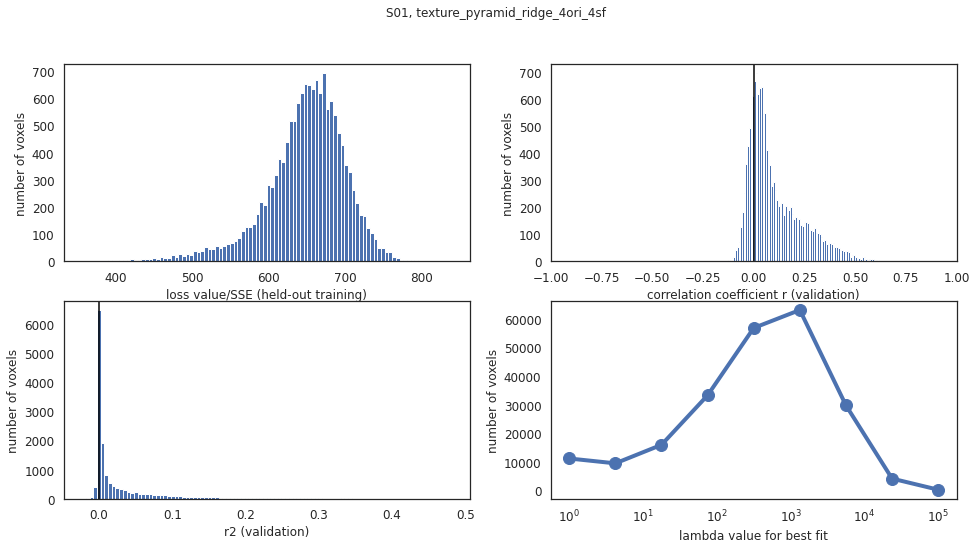

In [3]:
plot_utils.set_all_font_sizes(fs = 12)
summary_plots.plot_perf_summary(subject, fitting_type, out, fig_save_folder=fig_save_folder)

In [6]:
# plot_utils.plot_fit_summary_volume_space(subject, fitting_type,out, fig_save_folder)

In [5]:
summary_plots.plot_summary_pycortex(subject, fitting_type, out, port=33333)

Data is in 3d volume space
navigate browser to: 127.0.0.1:33333
Started server on port 33333
Stopping server


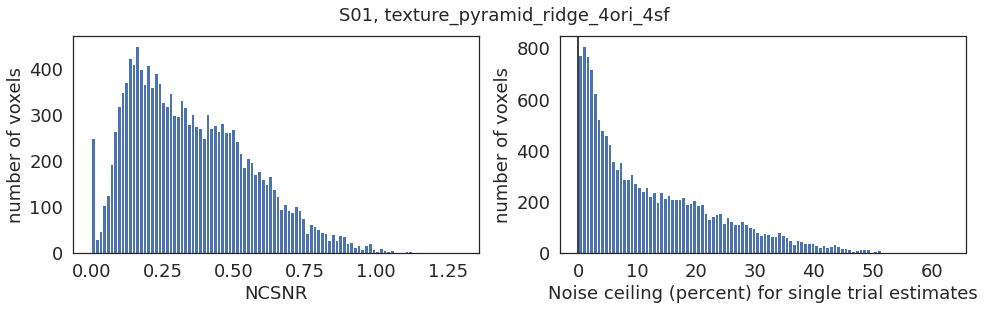

In [4]:
plot_utils.set_all_font_sizes(fs = 18)
summary_plots.plot_noise_ceilings(subject, fitting_type,out, fig_save_folder)

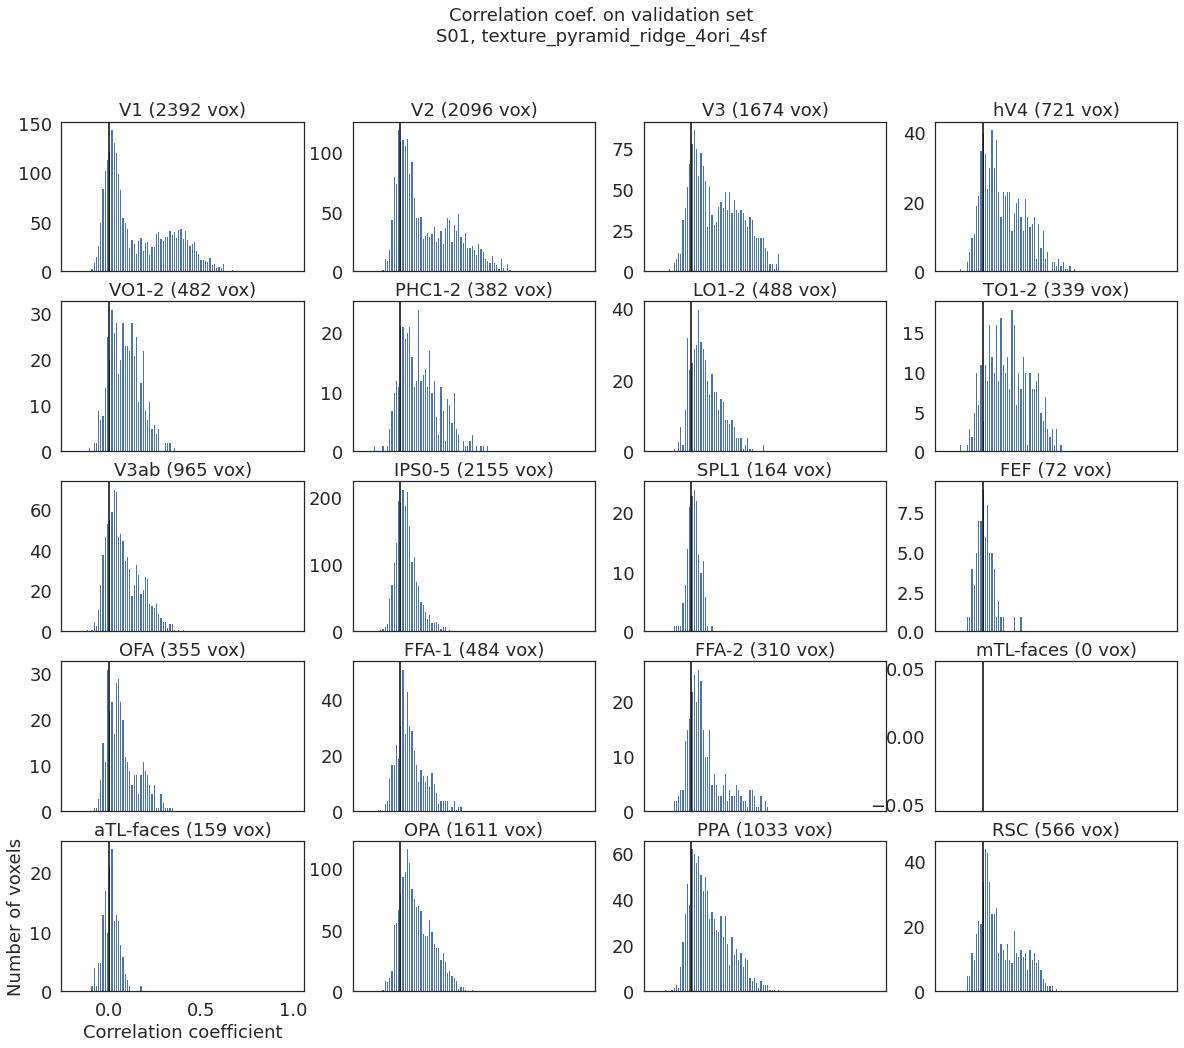

In [5]:
plot_utils.set_all_font_sizes(fs = 18)
summary_plots.plot_cc_each_roi(subject, fitting_type,out, fig_save_folder)

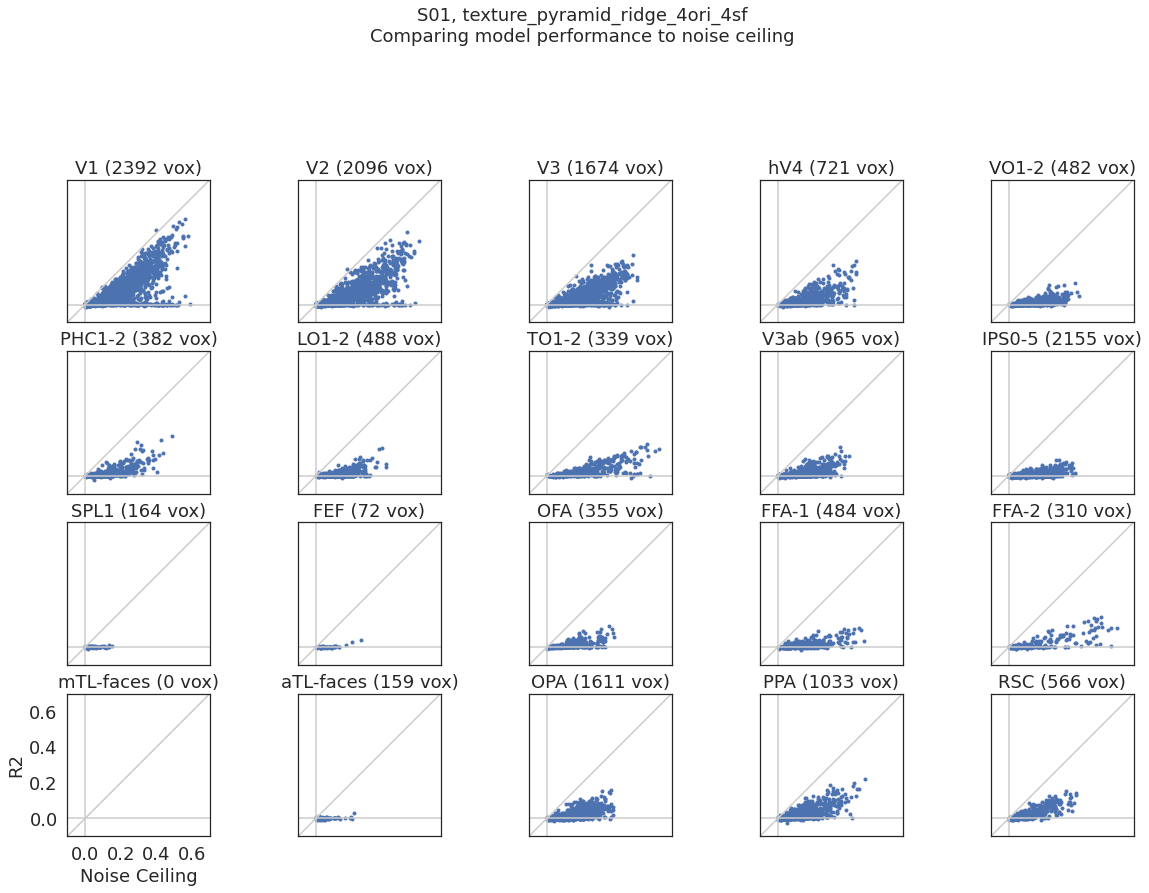

In [6]:
plot_utils.set_all_font_sizes(fs = 18)
summary_plots.plot_r2_vs_nc(subject, fitting_type,out, fig_save_folder, fig_size=(20,24))

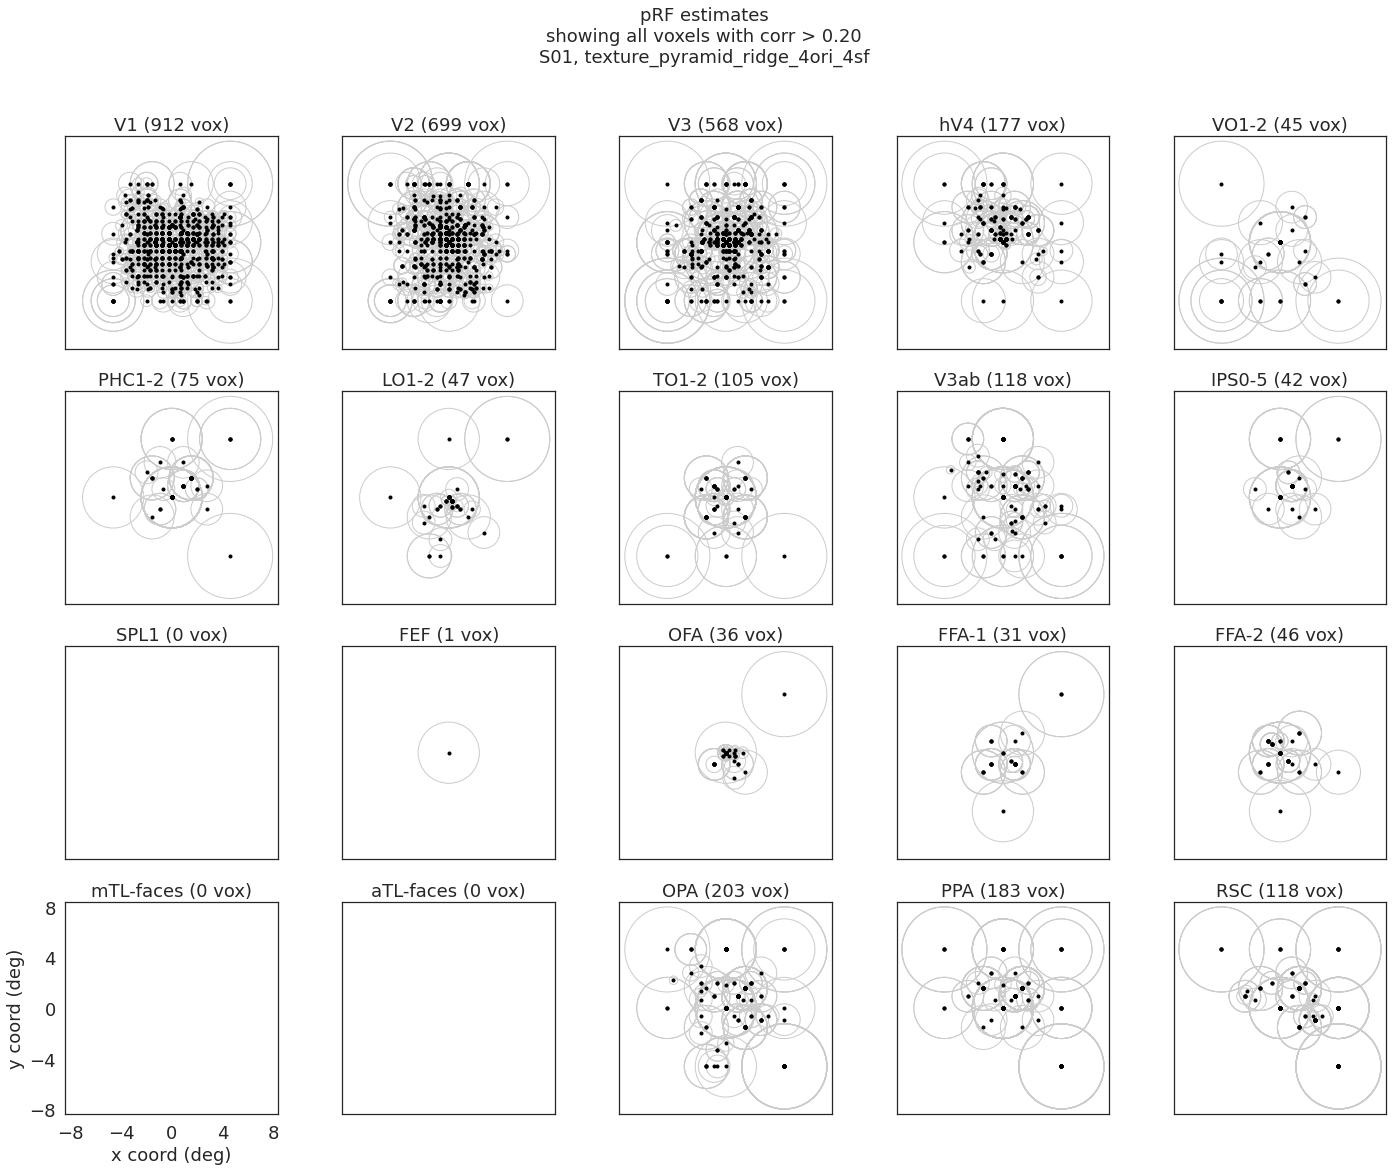

In [8]:
plot_utils.set_all_font_sizes(fs = 18)
spatial_fits.plot_spatial_rf_circles(subject, fitting_type,out, cc_cutoff = 0.20, fig_save_folder=fig_save_folder)

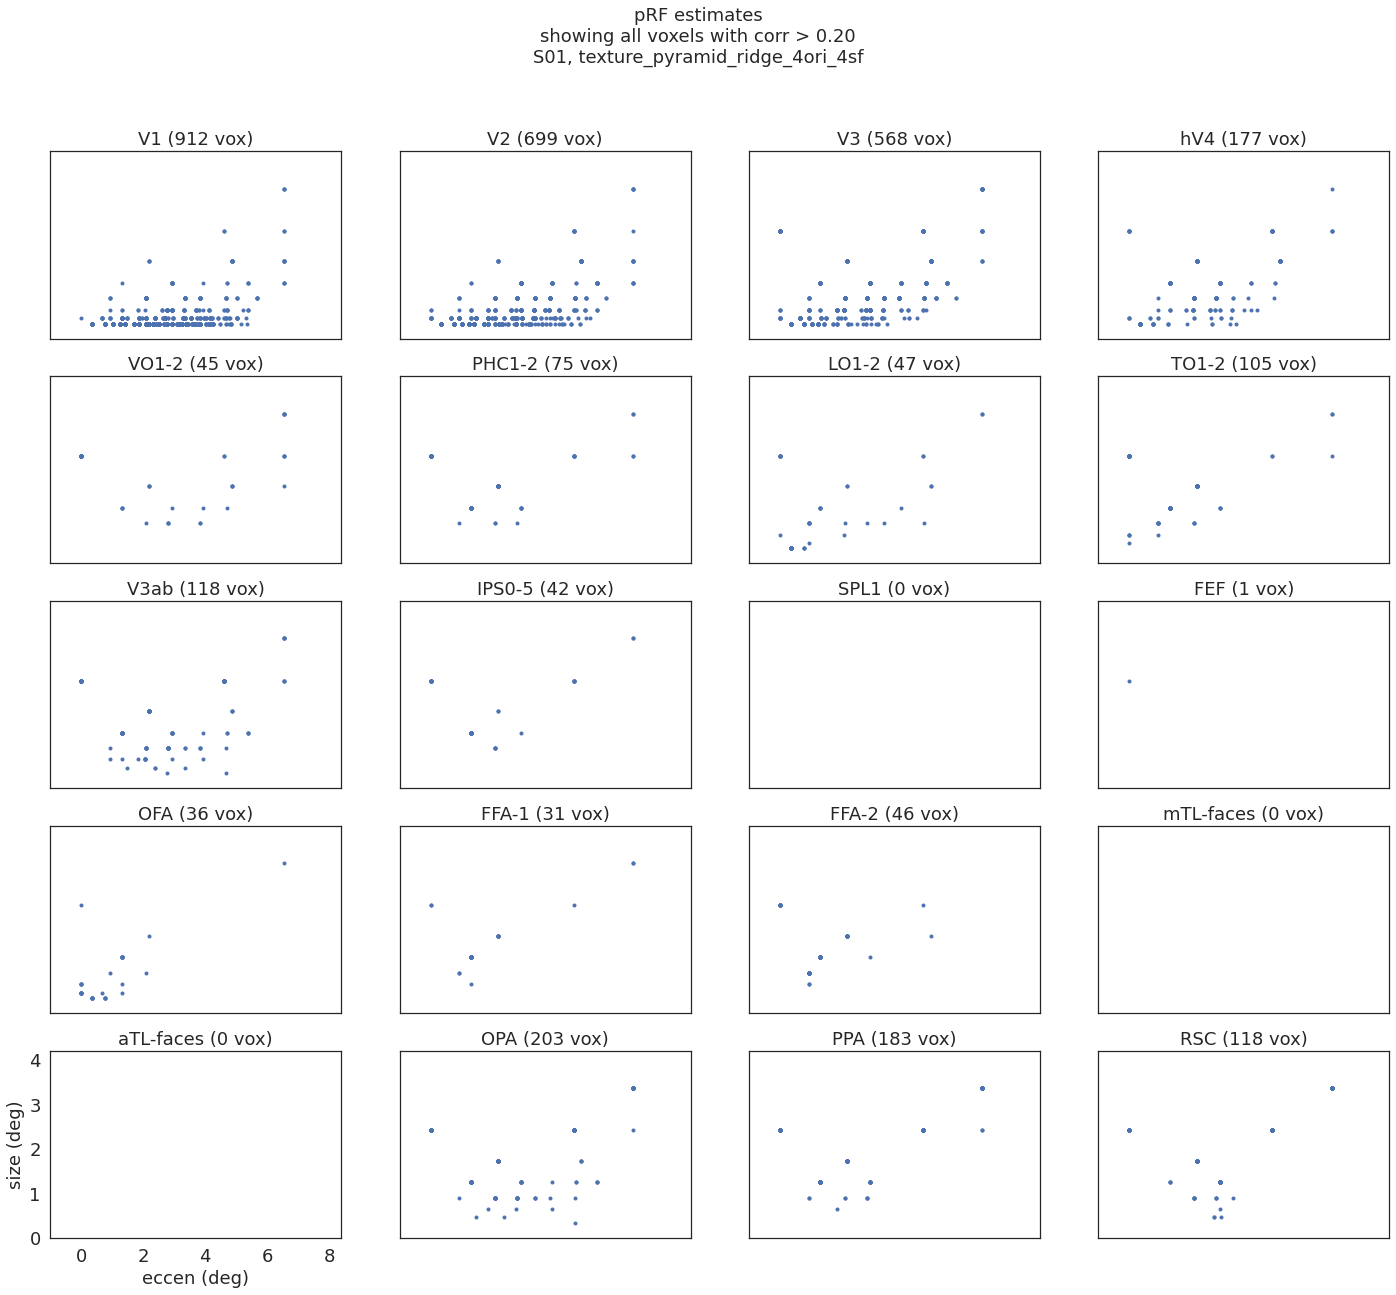

In [9]:
plot_utils.set_all_font_sizes(fs = 18)
spatial_fits.plot_size_vs_eccen(subject, fitting_type, out, cc_cutoff=0.20, fig_save_folder=fig_save_folder)

In [10]:
# Make plots in pycortex for variance partitioning analysis

import cortex

port=33333
# var_expl, ve_names = analysis_utils.process_two_way_var_part(out)
# max_ind = np.argmax(var_expl[:,1:3], axis=1)

# maps = [max_ind+1] + [var_expl[:,fi] for fi in range(var_expl.shape[1])]

# names = ['Prefered feature type (based on unique var)'] + ve_names
names = ['Full Model'] + ['Unique_' + ff for ff in out['feature_info'][1]]
maps = [out['val_cc'][:,0]] + [out['val_cc'][:,ff] - out['val_cc'][:,0] for ff in np.arange(1,out['val_cc'].shape[1])]
cmaps = ['PuBu']
mins = [0]
maxes = [0.2]

plot_utils.plot_maps_pycortex(maps, names, subject, out, fitting_type, port, cmaps=cmaps, mins=mins, maxes=maxes)

Data is in 3d volume space
navigate browser to: 127.0.0.1:33333
Started server on port 33333


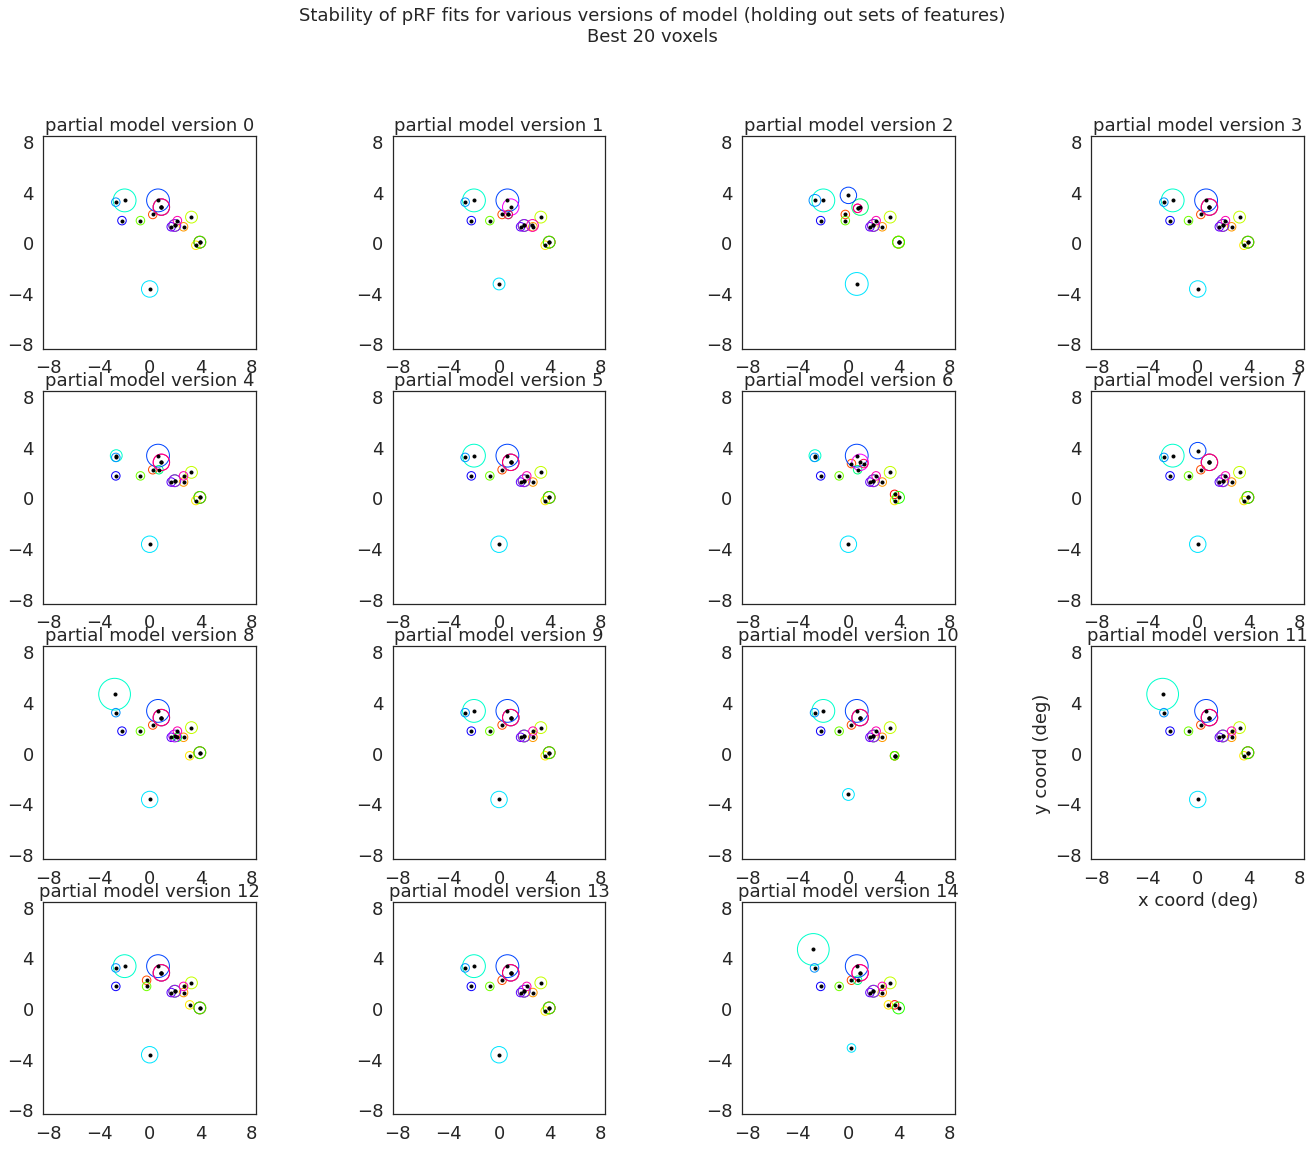

In [12]:
spatial_fits.plot_prf_stability_partial_versions(subject, out, cc_cutoff = 0.2, screen_eccen_deg = 8.4, fig_save_folder=fig_save_folder)


['pixel_stats', 'mean_magnitudes', 'mean_realparts', 'marginal_stats_lowpass_recons', 'variance_highpass_resid', 'magnitude_feature_autocorrs', 'lowpass_recon_autocorrs', 'highpass_resid_autocorrs', 'magnitude_within_scale_crosscorrs', 'real_within_scale_crosscorrs', 'magnitude_across_scale_crosscorrs', 'real_imag_across_scale_crosscorrs', 'real_spatshift_within_scale_crosscorrs', 'real_spatshift_across_scale_crosscorrs']


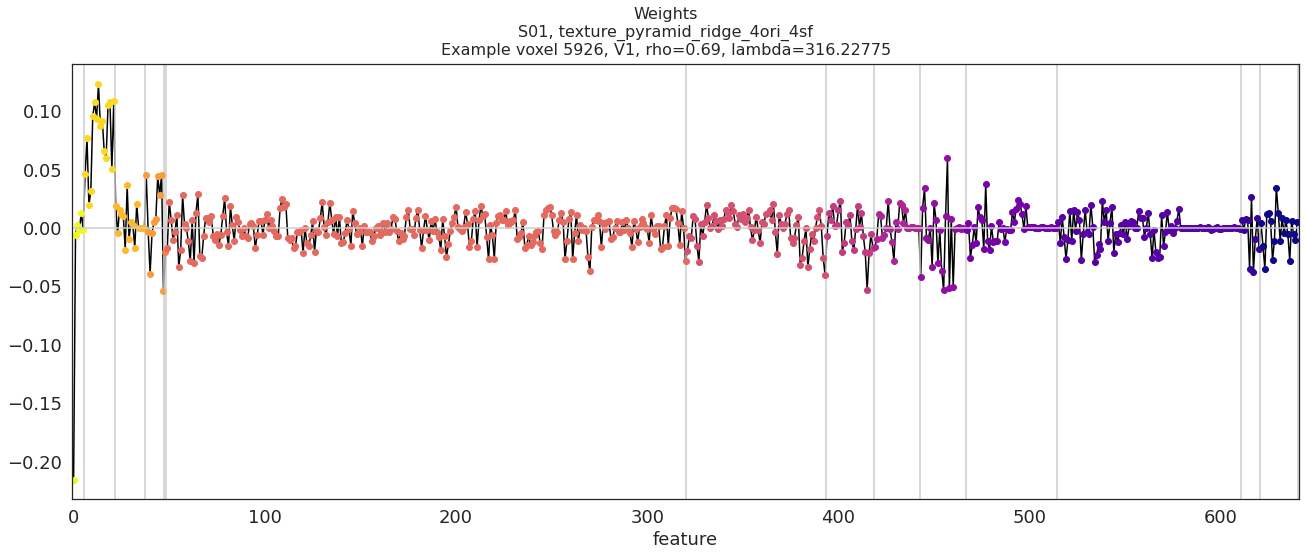

In [15]:
from plotting_and_analysis import texture_models
texture_models.plot_example_weights_texture(subject, fitting_type, out, fig_save_folder)

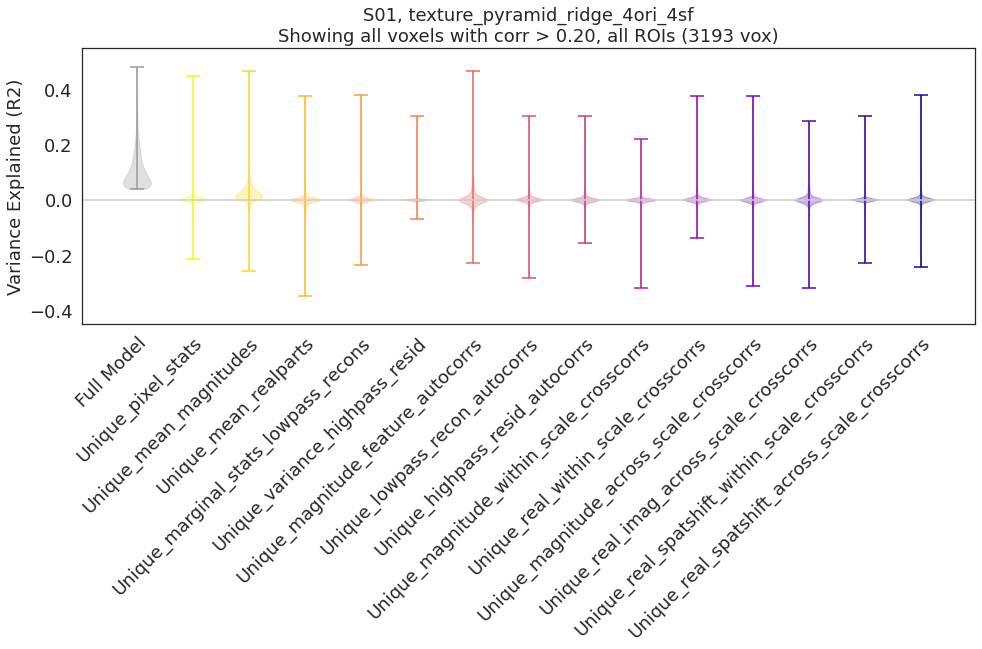

In [41]:
plot_utils.set_all_font_sizes(fs = 18)
cc_cutoff = 0.20
val_r2 = analysis_utils.get_r2(out)

# Compute variance explained by each feature type - how well does the model without that feature type
# do, compared to the model with all features? 
# (subtract later columns from the first column)
var_expl = np.tile(np.expand_dims(val_r2[:,0], axis=1), [1,val_r2.shape[1]-1]) - val_r2[:,1:] 
var_expl = np.concatenate([val_r2[:,0:1], var_expl], axis=1)
ve_names = ['Full Model'] + ['Unique_' + ff for ff in out['feature_info'][1]]

colors = cm.plasma(np.linspace(0,1,len(ve_names)-1))
graycolor = np.array([0.6, 0.6, 0.6, 1])
colors = np.concatenate((graycolor[np.newaxis,:], np.flipud(colors)), axis=0)

inds2use = out['val_cc'][:,0]>cc_cutoff

vp = plot_utils.violin_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                 title='S%02d, %s\nShowing all voxels with corr > %.2f, all ROIs (%d vox)'%(subject, fitting_type, \
                                                        cc_cutoff, np.sum(inds2use)), \
                                                        horizontal_line_pos=0, ylims=[-0.45, 0.55])
vp.create(data=var_expl[inds2use,:], new_fig=True)

plt.gcf().subplots_adjust(bottom=0.4)

if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'violin_uniq_var_texturefeat_allrois.png'))
    plt.savefig(os.path.join(fig_save_folder,'violin_uniq_var_texturefeat_allrois.pdf'))


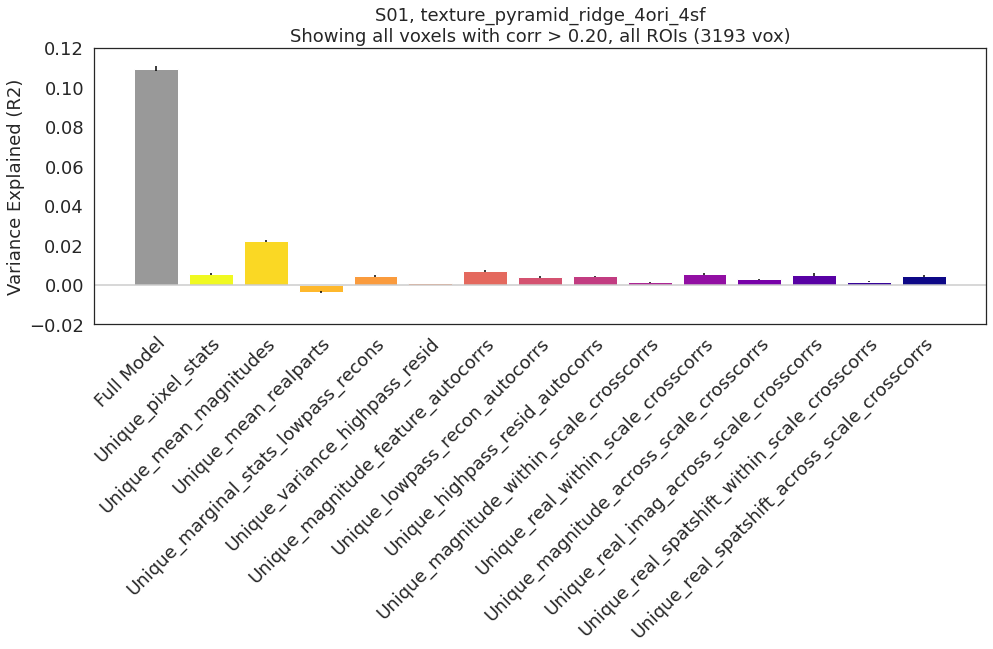

In [42]:
plot_utils.set_all_font_sizes(fs = 18)
cc_cutoff = 0.20
val_r2 = analysis_utils.get_r2(out)

# Compute variance explained by each feature type - how well does the model without that feature type
# do, compared to the model with all features? 
# (subtract later columns from the first column)
var_expl = np.tile(np.expand_dims(val_r2[:,0], axis=1), [1,val_r2.shape[1]-1]) - val_r2[:,1:] 
var_expl = np.concatenate([val_r2[:,0:1], var_expl], axis=1)
ve_names = ['Full Model'] + ['Unique_' + ff for ff in out['feature_info'][1]]

colors = cm.plasma(np.linspace(0,1,len(ve_names)-1))
graycolor = np.array([0.6, 0.6, 0.6, 1])
colors = np.concatenate((graycolor[np.newaxis,:], np.flipud(colors)), axis=0)

inds2use = out['val_cc'][:,0]>cc_cutoff

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                 title='S%02d, %s\nShowing all voxels with corr > %.2f, all ROIs (%d vox)'%(subject, fitting_type, \
                                                        cc_cutoff, np.sum(inds2use)), \
                                                        horizontal_line_pos=0, ylims=[-0.02, 0.12])
bp.create(data=var_expl[inds2use,:], new_fig=True)

plt.gcf().subplots_adjust(bottom=0.4)

if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'bars_uniq_var_texturefeat_allrois.png'))
    plt.savefig(os.path.join(fig_save_folder,'bars_uniq_var_texturefeat_allrois.pdf'))


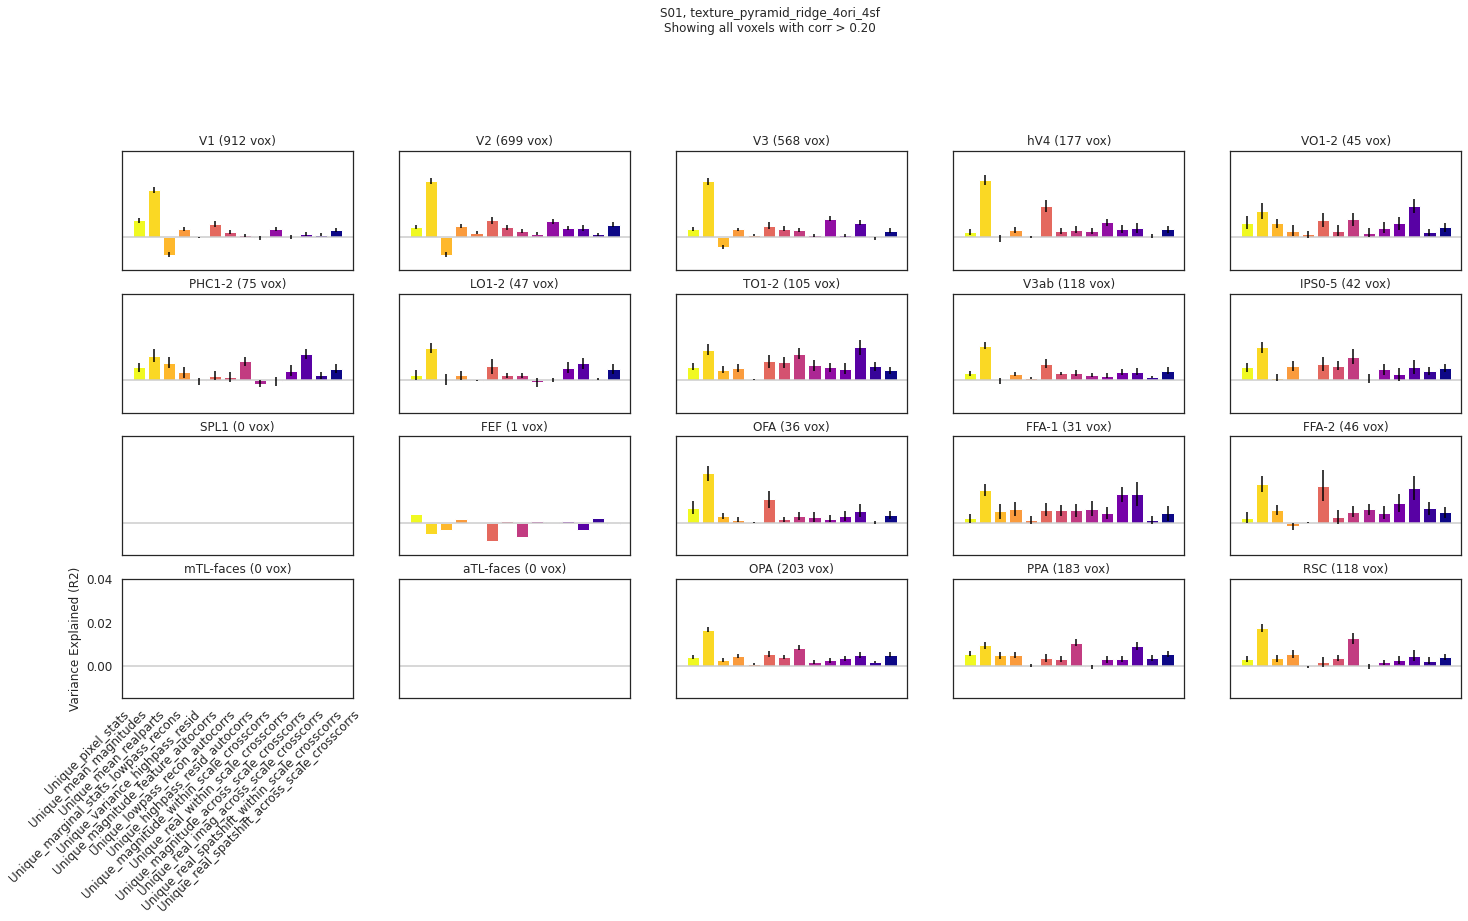

In [45]:
plot_utils.set_all_font_sizes(fs = 12)
cc_cutoff = 0.20
val_r2 = analysis_utils.get_r2(out)

var_expl = np.tile(np.expand_dims(val_r2[:,0], axis=1), [1,val_r2.shape[1]-1]) - val_r2[:,1:] 
# var_expl = np.concatenate([val_r2[:,0:1], var_expl], axis=1)
# ve_names = ['Full Model'] + ['Unique_' + ff for ff in out['feature_info'][1]]
ve_names = ['Unique_' + ff for ff in out['feature_info'][1]]

colors = cm.plasma(np.linspace(0,1,len(ve_names)))
# graycolor = np.array([0.6, 0.6, 0.6, 1])
# colors = np.concatenate((graycolor[np.newaxis,:], np.flipud(colors)), axis=0)
colors = np.flipud(colors)

inds2use = out['val_cc'][:,0]>cc_cutoff

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', plot_errorbars=True, \
                  horizontal_line_pos=0, ylims=[-0.015, 0.04])

plot_utils.create_roi_subplots(var_expl, inds2use, bp, subject, out, \
                    suptitle='S%02d, %s\nShowing all voxels with corr > %.2f'%(subject, fitting_type, cc_cutoff))

plt.gcf().subplots_adjust(bottom=0.5)

if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'uniq_var_bars_texturefeat_eachroi.pdf'))
    plt.savefig(os.path.join(fig_save_folder,'uniq_var_bars_texturefeat_eachroi.png'))

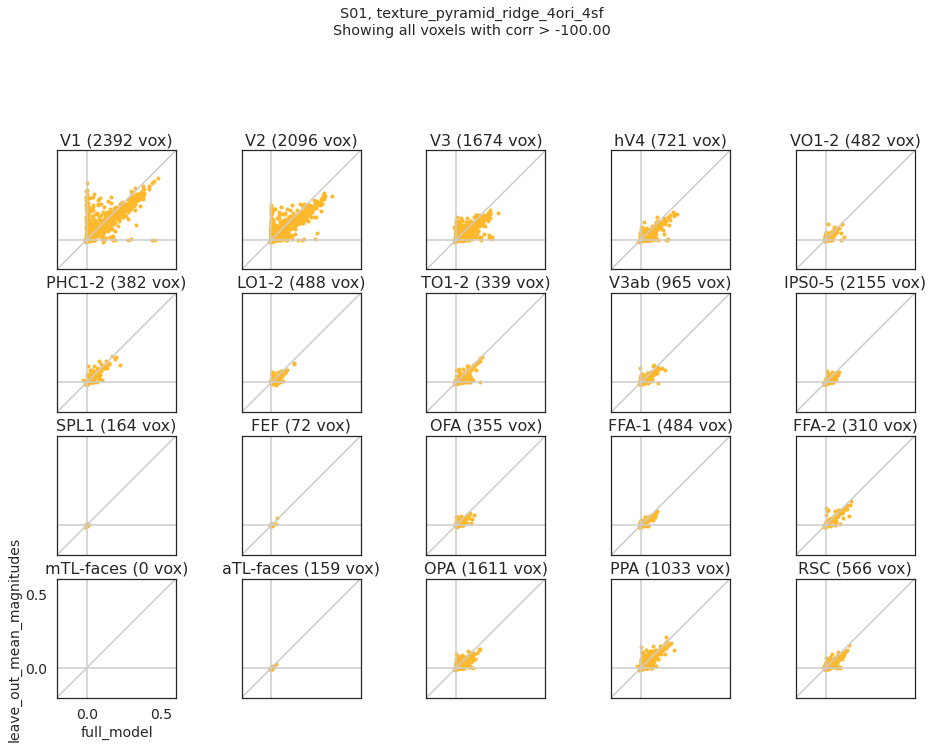

In [5]:
pp1=0
pp2=2

cc_cutoff = -100
val_r2 = analysis_utils.get_r2(out)

if len(out['best_params'])>6:
    partial_version_names = out['best_params'][6]
else:
    partial_version_names = out['partial_version_names']
        
colors = cm.plasma(np.linspace(0,1,len(out['feature_info'][1])))
colors = np.flipud(colors)
color = colors[pp2]

inds2use = out['val_cc'][:,0]>cc_cutoff

sp = plot_utils.scatter_plot(color=color, xlabel=partial_version_names[pp1], ylabel=partial_version_names[pp2], xlims=[-0.2, 0.6], ylims=[-0.2, 0.6], \
                  xticks=[0, 0.5], yticks=[0, 0.5],\
                 title='S%02d, %s\nShowing all voxels with corr > %.2f, all ROIs (%d vox)'%(subject, fitting_type, \
                                                        cc_cutoff, np.sum(inds2use)), \
                                                        show_diagonal=True, show_axes=True);
plot_utils.create_roi_subplots(val_r2[:,[pp1, pp2]], inds2use, sp, subject, out,\
                                      suptitle='S%02d, %s\nShowing all voxels with corr > %.2f'%(subject, fitting_type, cc_cutoff),\
                                      label_just_corner=True, figsize=(16,20))

plt.gcf().subplots_adjust(bottom=0.5)
if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'compare_%s_vs_%s_scatter_eachroi.pdf'%(partial_version_names[pp1], partial_version_names[pp2])))
    plt.savefig(os.path.join(fig_save_folder,'compare_%s_vs_%s_scatter_eachroi.png'%(partial_version_names[pp1], partial_version_names[pp2])))

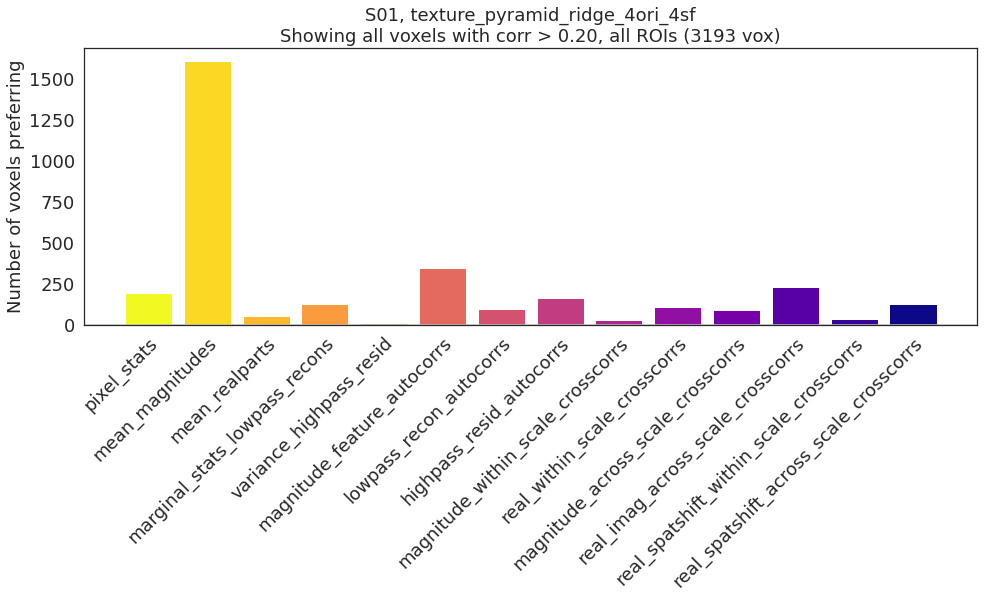

In [17]:
plot_utils.set_all_font_sizes(fs = 18)
cc_cutoff = 0.20

# Compute variance explained by each feature type - how well does the model without that feature type
# do, compared to the model with all features? 
# (subtract later columns from the first column)
n_feature_types = len(out['feature_info'][1])
val_r2 = analysis_utils.get_r2(out)

var_expl = np.tile(np.expand_dims(val_r2[:,0], axis=1), [1,n_feature_types]) - val_r2[:,1:] 
max_ve  = np.argmax(var_expl, axis=1)

inds2use = out['val_cc'][:,0]>cc_cutoff

unvals = np.arange(0,n_feature_types)
counts = np.array([np.sum(np.logical_and(max_ve==ff, inds2use)) for ff in unvals])
counts = counts[np.newaxis,:]

ve_names = out['feature_info'][1]
colors = cm.plasma(np.linspace(0,1,len(ve_names)))
colors = np.flipud(colors)

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Number of voxels preferring', \
                 title='S%02d, %s\nShowing all voxels with corr > %.2f, all ROIs (%d vox)'%(subject, fitting_type, \
                                                        cc_cutoff, np.sum(inds2use)), \
                                                        horizontal_line_pos=0, ylims=None)
bp.create(data=counts, new_fig=True)

plt.gcf().subplots_adjust(bottom=0.4)

if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'hist_highest_uniqvar_features_allrois.pdf'))
    plt.savefig(os.path.join(fig_save_folder,'hist_highest_uniqvar_features_allrois.png'))
